# Retrieving OpenStreetMap data for the MIKSERI project

Custom workflow for downloading POI data form OpenStreetMap from the MIKSERI-project case areas. 
This notebook was originally modified from [automating GIS processes 2020 course materials](https://autogis-site.readthedocs.io/en/latest/notebooks/L6/retrieve_osm_data.html).

Sources / References: 

- © OpenStreetMap contributors 2021. (see [OSM copyright and license](https://www.openstreetmap.org/copyright))
- [osmnx](https://osmnx.readthedocs.io/en/stable/) (version 1.0.1) Python package + Boeing 2017 ([link to article available on  research gate](https://www.researchgate.net/publication/309738462_OSMNX_New_Methods_for_Acquiring_Constructing_Analyzing_and_Visualizing_Complex_Street_Networks))
- AutoGIS 2020 materials [autogis.github.io](autogis.github.io) and/or Tenkanen, Heikinheimo & Whipp 2021 (soon to be) available at [pythongis.org](pythongis.org)

## Introduction

### MIKSERI project

The MIKSERI-project (*Lähiympäristöjen kehittäminen kaupunkikudosten ja toiminnallisen sekoittuneisuuden näkökulmasta*) focuses on urban development from the perspective of functional mixes across urban fabrics. 
[MIKSERI project description in Finnish.](https://www.syke.fi/fi-FI/Tutkimus__kehittaminen/Tutkimus_ja_kehittamishankkeet/Hankkeet/Lahiymparistojen_kehittaminen_kaupunkikudosten_ja_toiminnallisen_sekoittuneisuuden_nakokulmasta)



### OpenStreetMap

OpenStreetMap (OSM) is a free and editable worldmap available at www.openstreetmap.org. OpenStreetMap is a community effort - anyone is free to edit the map as long as they follow the commonly agreed principles (there are currently more than 4 million contributors) ([stats from OSM wiki, November 2019](http://wiki.openstreetmap.org/wiki/Stats)). OSM contains data about streets, buildings,  services and landuse. You can also sign up as a contributor if you want to edit the map. More details about OpenStreetMap and its contents are available in the [OpenStreetMap Wiki](https://wiki.openstreetmap.org/wiki/Main_Page).

There are different ways of accessing OSM data for further analysis. This notebook introduces the use of osmnx Python package that accesses the data via the [OverPass API](http://wiki.openstreetmap.org/wiki/Overpass_API).

### OSMnx

 [OSMnx](https://github.com/gboeing/osmnx) (Boeing 2017) is a Python module that can be used to retrieve, construct, analyze, and visualize street networks from OpenStreetMap, and to retrieve data about Points of Interest (POIs) such as restaurants, schools, and lots of different kind of services. It is also easy to conduct network routing based on walking, cycling or driving by combining OSMnx functionalities with a package called [NetworkX](https://networkx.github.io/documentation/stable/).


- Boeing, G. 2017. ["OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks."](https://www.researchgate.net/publication/309738462_OSMnx_New_Methods_for_Acquiring_Constructing_Analyzing_and_Visualizing_Complex_Street_Networks) Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004

- Interview: ["Meet the developer: Introduction to OSMnx package by Geoff Boeing"](https://www.youtube.com/watch?v=Q0uxu25ddc4&list=PLs9D4XVqc6dCAhhvhZB7aHGD8fCeCC_6N).

This notebook has been tested to work with osmnx version 1.0.1 and Python 3.8 in February 2021.

## Python environment

The Python environment was set up following these steps:

1. Install Anaconda (or Miniconda) on your computer
2. Instructions for creating a conda environment including basic GIS tools is available on the [AutoGIS course page](https://autogis-site.readthedocs.io/en/latest/course-info/create-python-gis-env.html). You can use the provided [yaml file](https://raw.githubusercontent.com/Automating-GIS-processes/site/master/ci/py38-GIS.yaml) (comes with some extra packages not needed in here..) for creating the environment.

In [1]:
import os
import glob
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Settings / custom functions

### Proxy server

In [2]:
# Organization-spesicif proxy settings in separate file my_proxy.py - file is ignored by git.
# Might be needed for fetching OSM or background maps over the network.. (Comment out if not needed..)
from my_proxy import http_proxy

os.environ['http_proxy'] = http_proxy
os.environ['https_proxy'] = http_proxy

### Output folder

In [3]:
# Output folder (note, contents of this folder are ignored by git!)
out_folder = r"..\results\downloaded_pois"

if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    print("created", out_folder)
    
else: 
    print(out_folder, "exists.")

..\results\downloaded_pois exists.


### Functions for repeating the process

Function for fetching the data. Check Example section for a simple run-through of the process.

In [4]:
def get_pois(row, tags, cols, renamings):
    """Function for fetching OSM data for each row in a polygon geodataframe"""
    
    # GET THE DATA
    print("Fetchin POIs from", row["name"])
    pois = ox.geometries_from_polygon(row.geometry, tags)
    print("Got", len(pois), "objects")
    
    # Select columns for output file
    pois = pois[cols]
    
    # Rename columns
    pois = pois.rename(columns=renamings)

    return pois

Function for saving results per each region as a separate geopackage (easier to have separate files for further analysis steps.. would also be possible to save all in one file). 


Tags are combined in the process based on the tag lists. Polygon geometries are converted to point centroids in the process.

In [5]:
def save_selected(pois, gpkg, tag_dict, category="amenity"):
    """Select features based on tag dictionary, save separate layer to geopackage for each key."""
    
    for key in tag_dict.keys():
        
        # Select rows based on list of keys
        selected_pois = pois[pois[category].isin(tag_dict.get(key))].copy()
        
        selected_pois = selected_pois.reset_index(drop=True)
        
        # Add info of category to new column for potential further use..
        selected_pois["{}_reclass".format(category)] = key 
        
        # Save selected rows to geopackage as new layer
        print("Saving", len(selected_pois), f" objects ({key})..")
        selected_pois.to_file(gpkg, layer=key, driver="GPKG")

In [6]:
def save_pois_to_gpkg(pois, gpkg, amenity_tag_dict={"":""}, shop_tag_dict={"":""}, tourism_tag_dict={"":""}):
    """MIKSERI-spesific custom function for saving objects per category to geodataframe. 
    
    Converts polygon geom to point before saving, check for potential duplicates afterwards!"""
    
    ## PREPARE DATA FOR SAVING:
    
    # Save info of original geom type
    pois.loc[pois["geometry"].type=="Point", "source"] = "OSM_point"
    pois.loc[pois["geometry"].type=="Polygon", "source"] = "OSM_polygon"

    # Approximate polygon location using a point centroid 
    # Calculate centroid on-the-fly using a local projection (EPSG:3067)
    poly_centroids = pois.loc[pois["geometry"].type=="Polygon"].to_crs(3067).centroid.to_crs(4326)
    pois.loc[pois["geometry"].type=="Polygon", "geometry"] = poly_centroids
    
    # CUSTOM: REMOVE MATONPESUPAIKKA IF EXISTS 
    if any(pois.loc[pois["name"].isin(["matonpesupaikka", "Matonpesupaikka"])]):
        pois = pois.drop(pois.loc[pois["name"].isin(["matonpesupaikka", "Matonpesupaikka"])].index)
                    
    # CUSTOM: REMOVE shop=no 
    if any(pois.loc[pois["shop"].isin(["no"])]):
        pois = pois.drop(pois.loc[pois["shop"].isin(["no"])].index)
    
    # SAVE LAYERS PER SELECTED CATEGORIES (CUSTOM APPROACH FOR MIKSERI PROJECT PURPOSES..)
        
    # ALL SHOPS
    print("Saving", len(pois[pois["shop"].notnull()]), "objects (all shops)..")
    pois[pois["shop"].notnull()].to_file(gpkg, layer="all_shops", driver="GPKG")
                    
    #SHOP CATEGORIES
    save_selected(pois, gpkg, shop_tag_dict, category="shop")
    
    # ALL AMENITIES
    print("Saving", len(pois[pois["amenity"].notnull()]), "objects (all amenities)..")
    pois[pois["amenity"].notnull()].to_file(gpkg, layer="all_amenities", driver="GPKG")
    
    # AMENITY CATEGORIES
    save_selected(pois, gpkg, amenity_tag_dict, category="amenity")
    #could add saving all others.
    
    # ALL TOURISM
    print("Saving", len(pois[pois["tourism"].notnull()]), "objects (all tourism)..")
    pois[pois["tourism"].notnull()].to_file(gpkg, layer="all_tourism", driver="GPKG")
    
    # TOURISM CATEGORIES
    save_selected(pois, gpkg, tourism_tag_dict, category="tourism")
    #could add saving all others.
    
    print("DONE saving data to", gpkg, "\n")

## MIKSERI Case areas


Included regions: 
- Joensuu
- Tampere
- Kuopio
- Lappeenranta

#### Read in case area polygons from this repository

In [7]:
case_areas_fp = r"..\case_areas\MIKSERI_case_areas.geojson"
case_areas = gpd.read_file(r"..\case_areas\MIKSERI_case_areas.geojson")

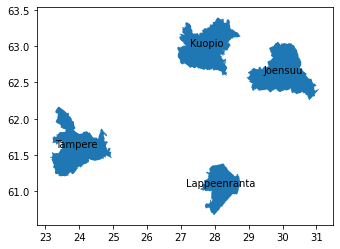

In [8]:
ax = case_areas.plot()

#Add names to plot to verify they went into correct polygons :D
case_areas.apply(lambda x: ax.annotate(text=x["name"], 
                                       xy=x.geometry.centroid.coords[0], 
                                       ha='center'),axis=1);

#### Projection

The polygons need to be in WGS84 (EPSG:4326) for osmnx.

In [9]:
case_areas.crs.name

'WGS 84'

In [10]:
# Ensure that epsg:4326 (in the default case, this is not needed, but no harm to reproject to existing crs)
case_areas = case_areas.to_crs(epsg=4326)

In [11]:
case_areas.crs.name

'WGS 84'

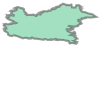

In [12]:
# Demo with one case; 0 = Lappeenranta; 3=Kuopio
case = case_areas.loc[3]
case.geometry

In [13]:
case

Id                                                          0
name                                                   Kuopio
geometry    POLYGON ((28.13315142426847 63.38697654903667,...
Name: 3, dtype: object

## Example - fetch data for one case area
Point-of-interest (POI) is a generic concept that describes point locations that represent places of interest. 
In OpenStreetMap, many POIs are described using the [amenity-tags](https://wiki.openstreetmap.org/wiki/Key:amenityhttps://wiki.openstreetmap.org/wiki/Key:amenity). 
We can, for excample, retrieve all restaurat locations by referring to the tag `amenity=restaurant`. See all available amenity categories from [OSM wiki](https://wiki.openstreetmap.org/wiki/Key:amenity). Various kinds of shops are tagged using [shop-tags](https://wiki.openstreetmap.org/wiki/Key:shop).

Here, we will retrieve all shops and amenities for further inspection.

In [14]:
# List key-value pairs for tags
#tags = {'amenity': 'restaurant'}
tags = {"amenity": True, 'shop':True, 'tourism':True}

# Retrieve restaurants
pois = ox.geometries_from_polygon(case.geometry, tags)

# Check the result
len(pois)

2862

Let's explore what kind of attributes we have in our GeoDataFrame:

In [15]:
pois.head(2)

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,element_type,amenity,geometry,addr:city,addr:country,name,religion,is_in,...,dog,reservation,sanitary_dump_station,shower,building:architecture,backcountry,place,produce,facebook,drive_through:covid19
0,node/34980260,34980260,node,parking,POINT (27.62741 62.88878),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/34980285,34980285,node,parking,POINT (27.62989 62.88945),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Available columns
#print(pois.columns.values)
len(pois.columns.values)

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


240

As you can see, there is quite a lot of (potential) information related to the amenities. Let's subset the columns and inspect the data further. Useful columns include at least `name`, `address information` and `opening_hours` information:

In [17]:
# Select some useful cols and print
cols = ['name', 'name:fi', 'amenity','shop','tourism','opening_hours', 
        'addr:city', 'addr:country', 'addr:housenumber', 'addr:postcode', 'addr:street', 
        'leisure', 'website', 'geometry']

# Print only selected cols
pois[cols].head()

,name,name:fi,amenity,shop,tourism,opening_hours,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,leisure,website,geometry
0,NaN,NaN,parking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (27.62741 62.88878)
1,NaN,NaN,parking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (27.62989 62.88945)
2,Männistön Pyhän Johanneksen Kirkko,NaN,place_of_worship,NaN,NaN,NaN,Kuopio,FI,NaN,NaN,NaN,NaN,NaN,POINT (27.69370 62.90690)
3,Puijo,NaN,NaN,NaN,attraction,NaN,Kuopio,FI,NaN,NaN,NaN,NaN,NaN,POINT (27.65611 62.90950)
4,Savon Pizza-Kebab,NaN,restaurant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (27.70601 62.91659)


In [18]:
print(pois.amenity.value_counts().head(15))

parking             1232
restaurant           106
school                77
bench                 74
shelter               61
social_facility       53
fuel                  51
fast_food             51
kindergarten          46
place_of_worship      39
bicycle_rental        37
cafe                  37
pub                   28
post_box              27
waste_basket          26
Name: amenity, dtype: int64


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
print(pois.tourism.value_counts().head(15))

information        42
picnic_site        42
artwork            30
museum             20
viewpoint          17
hotel              17
attraction         12
chalet             11
hostel              5
guest_house         4
camp_site           4
caravan_site        3
apartment hotel     3
gallery             2
wilderness_hut      1
Name: tourism, dtype: int64


In [20]:
print("shops:", len(pois[pois.shop.notnull()]))
print("amenities:", len(pois[pois.amenity.notnull()]))
print("tourism:", len(pois[pois.tourism.notnull()]))

shops: 402
amenities: 2261
tourism: 214


In [21]:
pois.head()

,unique_id,osmid,element_type,amenity,geometry,addr:city,addr:country,name,religion,is_in,...,dog,reservation,sanitary_dump_station,shower,building:architecture,backcountry,place,produce,facebook,drive_through:covid19
0,node/34980260,34980260,node,parking,POINT (27.62741 62.88878),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/34980285,34980285,node,parking,POINT (27.62989 62.88945),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/162657407,162657407,node,place_of_worship,POINT (27.69370 62.90690),Kuopio,FI,Männistön Pyhän Johanneksen Kirkko,christian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/197391072,197391072,node,NaN,POINT (27.65611 62.90950),Kuopio,FI,Puijo,NaN,"Kuopio, Finland",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/197420228,197420228,node,restaurant,POINT (27.70601 62.91659),NaN,NaN,Savon Pizza-Kebab,NaN,"Kelloniemi, Kuopio, Finland",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Result includes also polygons, we can restrict the result based on the geometry type
#pois[pois["geometry"].type=="Point"]

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Handle polygons (note, this might introduce duplicates into the data!)

In [23]:
pois.loc[pois["geometry"].type=="Point", "source"] = "OSM_point"
pois.loc[pois["geometry"].type=="Polygon", "source"] = "OSM_polygon"

# Approximate polygon location using a point centroid 
# Calculate centroid on-the-fly using a local projection (EPSG:3067)
poly_centroids = pois.loc[pois["geometry"].type=="Polygon"].to_crs(3067).centroid.to_crs(4326)
pois.loc[pois["geometry"].type=="Polygon", "geometry"] = poly_centroids

As we can see, there is a lot of  information available. Also, if some of the information need updating, you can go over to www.openstreetmap.org and edit the source data! :)

## Fetch POIs for all regions

### Selected tags and columns

In [24]:
# Tags to fetch
tags = {'amenity': True, 
        'shop':True, 
        'tourism':True
       }

# List of columns to select from the result
cols = ['name', 'name:fi', 'amenity','shop','tourism','opening_hours', 
        'addr:city', 'addr:country', 'addr:postcode', 'addr:street', 
        'geometry','website']

# Dictionary for renaming columns. Note! for shapefile output, max 8 characters will be stored!
renamings = {'name:fi': 'name_fi', 
             'addr:city' : 'addr_city', 
             'addr:country' : 'addr_country', 
             'addr:postcode' : 'addr_postcode', 
             'addr:street': 'addr_street'
                        }

In [25]:
#  layername Tag(s) dict for amenity classes that should get stored as separate layers
amenity_tag_dict = {"restaurants": ["restaurant", "fast_food"],
                    "cafes" : ["cafe"],
                    "pubs_clubs" : ["pub", "nightclub", "bar"],
                    "pharmacies": ["pharmacy"],
                    "libraries": ["library"],
                    "banks": ["bank"],
                    "theatres":["theatre"],
                    "cinemas": ["cinema"],
                    "kindergartens" : ["kindergarten", "childcare"]
                    # other amenities are omitted
                   }

In [26]:
#  layername Tag(s) dict for amenity classes that should get stored as separate layers
shop_tag_dict = { "alcohol_shops" : ["alcohol"],
                 "kiosks" : ["kiosk"],
                 "grocery_stores" : ["supermarket", "grocery", "convenience"],
                 "department_stores" : ["department_store", "variety_store"],
                 "bakery" : ["pastry", "bakery"], 
                 "personal_services" : ["beauty", "tattoo", "massage", "hairdresser"] ,
                 "clothing" : ["clothes", "shoes"],
                 "sports_outdoors" : ["sports", "outdoors"],
                 "opticians" :["optician"],
                 "florists" : ["florist"],
                }

In [27]:
tourism_tag_dict = {"hotels":["hotel", "motel", "hostel"],
                    "museums":["museum"]    
                    }

In [28]:
# Fetch amenities for all case areas (results come stacked into one Pandas Series..)
results = case_areas.apply(get_pois, tags=tags, cols=cols, renamings=renamings, axis=1)

Fetchin POIs from Lappeenranta
Got 2414 objects
Fetchin POIs from Tampere
Got 7488 objects
Fetchin POIs from Joensuu
Got 2559 objects
Fetchin POIs from Kuopio
Got 2862 objects


In [29]:
#selected_shop_tags = [value for values in shop_tag_dict.values() for value in values]

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
results[0]

,name,name_fi,amenity,shop,tourism,opening_hours,addr_city,addr_country,addr_postcode,addr_street,geometry,website
0,NaN,Vihtolan laavu,shelter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (28.13620 61.00983),NaN
1,NaN,Melkkolan laavu,shelter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (28.12402 60.92319),NaN
2,Simolan Alakosken laavu,NaN,shelter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (28.14716 60.90422),NaN
3,NaN,Simolan urh.kentta laavu,shelter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (28.15376 60.89940),NaN
4,NaN,Multamäen laavu,shelter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (27.96650 60.78614),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2409,IsoKristiina,NaN,NaN,mall,NaN,Mo-Sa 07:00-21:00; Su 10:00-21:00,Lappeenranta,NaN,53100,Brahenkatu,"POLYGON ((28.19404 61.05699, 28.19467 61.05707...",https://www.isokristiina.fi/
2410,NaN,NaN,fire_station,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((28.20276 61.05139, 28.20299 61.05126...",NaN
2411,NaN,NaN,fountain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((28.18719 61.06123, 28.18714 61.06131...",NaN
2412,NaN,NaN,parking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((28.20984 61.04719, 28.20987 61.04715...",NaN


In [31]:
# FOR EACH AREA, CREATE SEPARATE GPKG
for i in range(len(case_areas)):
    
    # INITIATE OUTPUT FILE AND SAVE STUDY AREA EXTENT
    area = case_areas[case_areas.index == i]
    area_name = area.at[i, "name"]
    print(area_name)
    
    # output file name
    gpkg = os.path.join(out_folder, "OSM_{}.gpkg".format(area_name))

    # Save study area extent 
    area.to_file(gpkg, layer="{}_region".format(area_name), driver="GPKG")

    # Save points
    save_pois_to_gpkg(results[i], 
                      gpkg=gpkg, 
                      amenity_tag_dict=amenity_tag_dict, 
                      shop_tag_dict=shop_tag_dict,
                      tourism_tag_dict=tourism_tag_dict
                     )

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Lappeenranta
Saving 356 objects (all shops)..
Saving 3  objects (alcohol_shops)..
Saving 10  objects (kiosks)..
Saving 41  objects (grocery_stores)..
Saving 4  objects (department_stores)..
Saving 5  objects (bakery)..
Saving 56  objects (personal_services)..
Saving 33  objects (clothing)..
Saving 11  objects (sports_outdoors)..
Saving 8  objects (opticians)..
Saving 3  objects (florists)..
Saving 1887 objects (all amenities)..
Saving 103  objects (restaurants)..
Saving 34  objects (cafes)..
Saving 23  objects (pubs_clubs)..
Saving 12  objects (pharmacies)..
Saving 13  objects (libraries)..
Saving 6  objects (banks)..
Saving 2  objects (theatres)..
Saving 1  objects (cinemas)..
Saving 33  objects (kindergartens)..
Saving 184 objects (all tourism)..
Saving 12  objects (hotels)..
Saving 14  objects (museums)..
DONE saving data to ..\results\downloaded_pois\OSM_Lappeenranta.gpkg 

Tampere
Saving 1072 objects (all shops)..
Saving 19  objects (alcohol_shops)..
Saving 46  objects (kiosks)..


## Explore results

In [32]:
files = glob.glob(os.path.join(out_folder, "*gpkg"))

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
files

['..\\results\\downloaded_pois\\OSM_Joensuu.gpkg',
 '..\\results\\downloaded_pois\\OSM_Kuopio.gpkg',
 '..\\results\\downloaded_pois\\OSM_Lappeenranta.gpkg',
 '..\\results\\downloaded_pois\\OSM_Tampere.gpkg']

In [34]:
results[1][results[1]["amenity"]=="childcare"]

,name,name_fi,amenity,shop,tourism,opening_hours,addr_city,addr_country,addr_postcode,addr_street,geometry,website,source
1222,Kurikankulman päiväkoti,NaN,childcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.66463 61.46298),NaN,OSM_point
1223,Kurikansiiven päiväkoti,NaN,childcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.66596 61.46344),NaN,OSM_point
1224,Kurikan Helmen päiväkoti,NaN,childcare,NaN,NaN,NaN,Pirkkala,NaN,33960,Aittokorventie,POINT (23.66265 61.46341),NaN,OSM_point
1857,Pereen päiväkoti,NaN,childcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.71097 61.47141),NaN,OSM_point
1963,International Early Education Center,NaN,childcare,NaN,NaN,7:15-17:00,Tampere,NaN,33230,Pirkankatu,POINT (23.74055 61.49813),NaN,OSM_point
2535,Linnainmaan päiväkoti,NaN,childcare,NaN,NaN,NaN,NaN,NaN,NaN,Helakallionkatu,POINT (23.89397 61.49062),NaN,OSM_point
2755,Touhula,NaN,childcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.85889 61.44858),NaN,OSM_point
3808,Sammon päiväkoti,NaN,childcare,NaN,NaN,NaN,Tampere,NaN,33540,Lemminkäisenkatu,POINT (23.80958 61.49837),NaN,OSM_polygon
3977,Iidesrannan päiväkoti,NaN,childcare,NaN,NaN,NaN,Tampere,NaN,33100,Iidesranta,POINT (23.78804 61.49021),NaN,OSM_polygon
4487,Kurikanpirtin päiväkoti,NaN,childcare,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (23.66200 61.46308),NaN,OSM_polygon


### Potential duplicates

First round of quality assurance: check for duplicated POI names. Requires further visual inspection (e.g. in QGIS). 
For example, it is likely that there are several Hesburgers or Subways in one region, but less likely that there are several "Ninan Keittiö" in Tampere --> check manually and remove potential duplicates..

In [35]:
def explore_duplicates(gpkg, layer="restaurants"):
    
    print("\n-------", gpkg.split("_")[1][:-5], layer, "- potential duplicates------------")
    
    data = gpd.read_file(gpkg, layer=layer)
    
    #counts = pd.DataFrame(data.name.value_counts(), columns=["count"])
    #print(data.name.value_counts())
    
    counts = pd.DataFrame(data.name.value_counts())
    if len(counts[counts["name"] > 1])>0:
        print(counts[counts["name"] > 1])

for gpkg in files: 
    
    print("\n-----------")
    print(os.path.basename(gpkg))
    for layer in ["restaurants", "cafes", "pubs_clubs", "kindergartens"]:
        explore_duplicates(gpkg, layer)


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of itera


-----------
OSM_Joensuu.gpkg

------- poi restaurants - potential duplicates------------
                  name
Subway               4
Hesburger            2
Kotipizza            2
Sulo                 2
Burger King          2
Pizzapojat           2
Mihailin Taverna     2

------- poi cafes - potential duplicates------------

------- poi pubs_clubs - potential duplicates------------


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



------- poi kindergartens - potential duplicates------------
                        name
Gävlenlinnan päiväkoti     2
Marjalan päiväkoti         2
Linnunlahden päiväkoti     2

-----------
OSM_Kuopio.gpkg

------- poi restaurants - potential duplicates------------
           name
Hesburger     4
Kotipizza     2
Subway        2

------- poi cafes - potential duplicates------------


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



------- poi pubs_clubs - potential duplicates------------

------- poi kindergartens - potential duplicates------------

-----------
OSM_Lappeenranta.gpkg

------- poi restaurants - potential duplicates------------
           name
Hesburger     3
Don Papa      2
Kotipizza     2
Pamukkale     2

------- poi cafes - potential duplicates------------


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:



------- poi pubs_clubs - potential duplicates------------

------- poi kindergartens - potential duplicates------------

-----------
OSM_Tampere.gpkg

------- poi restaurants - potential duplicates------------


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


                       name
Subway                   14
Kotipizza                11
Hesburger                 7
Pancho Villa              5
McDonald's                4
Burger King               3
Zarillo                   3
Pepper                    2
Hanko Sushi               2
Pizza Service             2
Captain Hook              2
Ninan keittiö             2
Kasvisravintola Gopal     2

------- poi cafes - potential duplicates------------
                 name
Brander             2
kahvila             2
Robert's Coffee     2
Ståhlberg           2
Arnold's            2
Café Linkosuo       2

------- poi pubs_clubs - potential duplicates------------

------- poi kindergartens - potential duplicates------------


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


                          name
Nekalan päiväkoti            3
Touhula                      3
Harjunsalon päiväkoti        2
Menkalan päiväkoti           2
Tursolan päiväkoti           2
Linnainmaan päiväkoti        2
Omenatarhan päiväkoti        2
Kurikan Helmen päiväkoti     2
Viinikan päiväkoti           2


### Visualize

Simple maps for quick visual check

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Joensuu_restaurants


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Kuopio_restaurants


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Lappeenranta_restaurants


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Tampere_restaurants


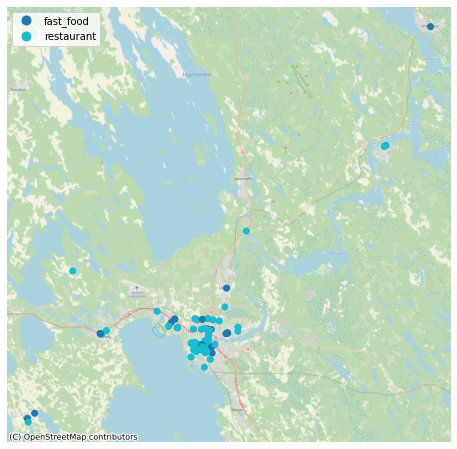

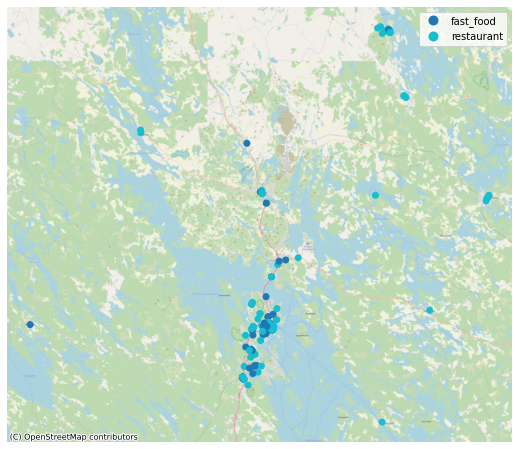

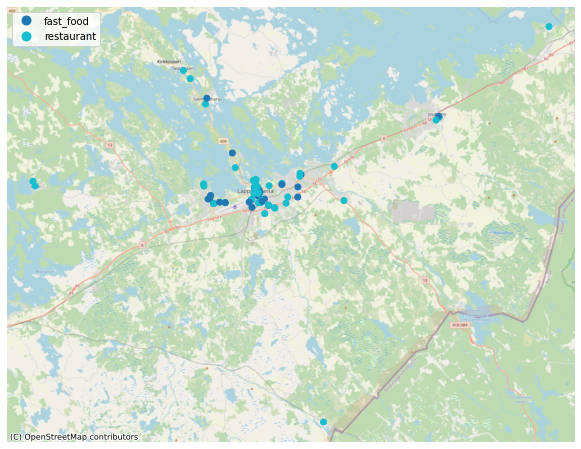

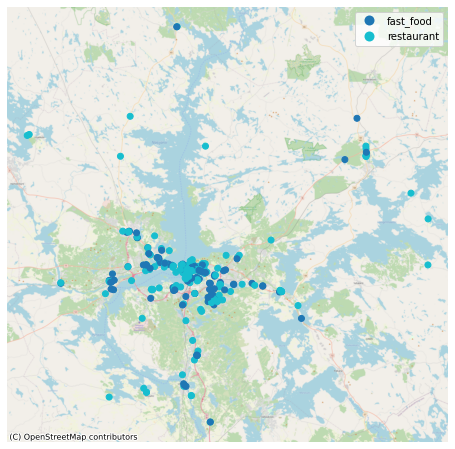

In [37]:
import fiona
import contextily as ctx

#package = "OpenStreetMap_cafes_and_restaurants_FEB2021.gpkg"

for gpkg in files: 
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    data = gpd.read_file(gpkg, layer="restaurants")
    layername="{}_restaurants".format(os.path.basename(gpkg).split("_")[1][:-5])
    
    print(layername)
    
    #Re-project for plotting with basemap
    data = data.to_crs(epsg=3857)

    # Fetch amenities for all case areas
    data.plot(ax=ax, column="amenity", legend=True)
    
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    plt.axis("off")
    
    # Uncomment for saving img file and edit filepath if needed..
    #plt.savefig(os.path.join(r"..\img", layername + ".png"), dpi=300)

## Next steps

- Manual check of data quality (start with potential duplicates)
- Accessibility analysis